## Imports and Setup


In [2]:
# This Colab requires TF 2.5.
#!pip install -U "tensorflow>=2.5" #2.8.0 is fine, I assume 2.9.0 is fine too

In [2]:
# not sure all of these are needed

import os

import matplotlib
import matplotlib.pyplot as plt

import io
import numpy as np

from PIL import Image


import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

## Utilities

- Map of Model Name to TF Hub handle


In [4]:
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

## Build a detection model and load pre-trained model weights

Here we will choose which Object Detection model we will use.
Select the architecture and it will be loaded automatically.
If you want to change the model to try other architectures later, just change the next cell and execute following ones.

**Tip:** if you want to read more details about the selected model, you can follow the link (model handle) and read additional documentation on TF Hub. After you select a model, we will print the handle to make it easier.

In [ ]:
'SSD MobileNet V1 FPN 640x640'
#'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1'
'SSD MobileNet v2 320x320'

In [5]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'SSD MobileNet V1 FPN 640x640' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:SSD MobileNet V1 FPN 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1


In [34]:
model_handle

'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1'

## Loading the selected model from TensorFlow Hub

Here we just need the model handle that was selected and use the Tensorflow Hub library to load it to memory.


In [6]:
print('loading model...')
hub_model = hub.load(model_handle) 
print('model loaded!')

loading model...


2022-08-27 12:26:44.886752: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


model loaded!


# Load image/s

In [8]:
!ls ../raw_data/lemons

IMG_3883.jpg   IMG_3884.jpg   IMG_3885.jpg   lemon_test.jpg


In [25]:
X_pred = np.stack([np.array(Image.open(f'../raw_data/lemons/{img_path}').resize((640,640))) for img_path in os.listdir('../raw_data/lemons')])

In [27]:
X_pred.shape

(4, 640, 640, 3)

## Doing the inference

To do the inference we just need to call our TF Hub loaded model.

Things you can try:
* Print out `result['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* inspect other output keys present in the result. A full documentation can be seen on the models documentation page (pointing your browser to the model handle printed earlier)

In [28]:
X_pred[1]

array([[[ 35,  54, 219],
        [ 35,  54, 219],
        [ 35,  54, 219],
        ...,
        [ 36,  56, 229],
        [ 42,  59, 233],
        [ 45,  62, 236]],

       [[ 35,  54, 219],
        [ 35,  54, 219],
        [ 35,  54, 219],
        ...,
        [ 37,  56, 230],
        [ 42,  60, 233],
        [ 45,  61, 235]],

       [[ 35,  54, 219],
        [ 35,  54, 219],
        [ 35,  54, 219],
        ...,
        [ 40,  57, 231],
        [ 44,  60, 234],
        [ 45,  61, 235]],

       ...,

       [[ 38,  53, 180],
        [ 38,  53, 180],
        [ 38,  53, 181],
        ...,
        [ 32,  63, 239],
        [ 32,  61, 237],
        [ 34,  58, 238]],

       [[ 38,  53, 180],
        [ 38,  53, 180],
        [ 38,  53, 181],
        ...,
        [ 34,  62, 239],
        [ 33,  60, 238],
        [ 34,  57, 238]],

       [[ 40,  53, 181],
        [ 39,  52, 180],
        [ 39,  52, 181],
        ...,
        [ 36,  62, 239],
        [ 35,  59, 238],
        [ 36,  57, 238]]

In [32]:
def find_lemon(img_array):

    X = np.expand_dims(img_array, axis = 0)

    # running inference
    results = hub_model(X)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
#   print(result.keys())

    first_lemon_id = np.argwhere(results['detection_classes'].numpy()[0] == 55)[0][0] # class 55 = orange

    bbox = (results['detection_boxes'][0][first_lemon_id] * 640).numpy().astype(int)

    ymin, xmin, ymax, xmax = bbox

    old_img = X[0]
    padding = 8
    new_img = X[0][ymin-padding:ymax+padding, xmin-padding:xmax+padding]

    return old_img, new_img

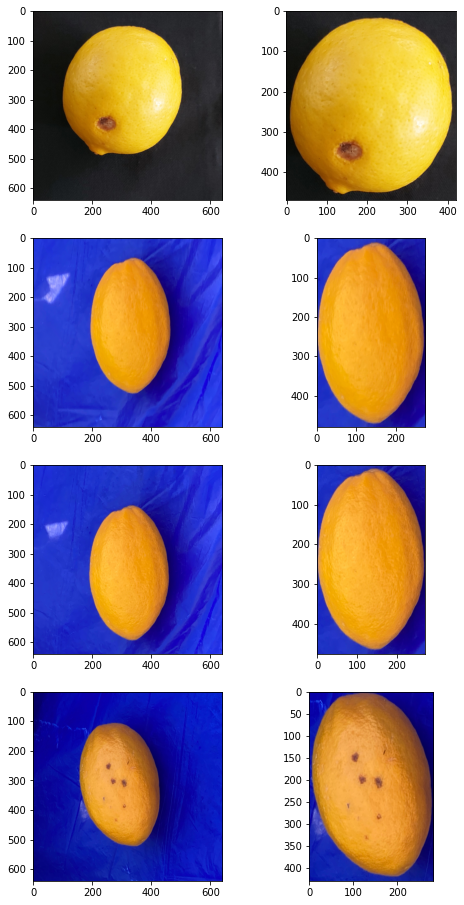

In [33]:
fig, axes = plt.subplots(len(X_pred), 2, figsize = (8, 16))

for idx, img in enumerate(X_pred):

    old_img, new_img = find_lemon(X_pred[idx])


    axes[idx, 0].imshow(old_img)
    axes[idx, 1].imshow(new_img)

In [37]:
X_pred.shape

(1, 640, 640, 3)

In [46]:
def find_a_lemon(img):
    
    X = np.expand_dims(img, axis = 0)

    # running inference
    results = hub_model(X)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
#     print(result.keys())

    first_lemon_id = np.argwhere(results['detection_classes'].numpy()[0] == 55)[0][0] # class 55 = orange

    bbox = (results['detection_boxes'][0][first_lemon_id] * 640).numpy().astype(int)

    ymin, xmin, ymax, xmax = bbox

    padding = 8
    new_img = X[0][ymin-padding:ymax+padding, xmin-padding:xmax+padding]

    return new_img

In [49]:
img = Image.open('../raw_data/lemons/lemon_test.jpg').resize((640,640))

X_pred = np.expand_dims(np.array(img), axis = 0)

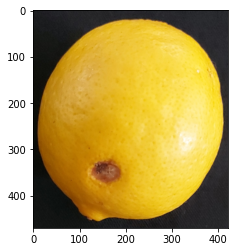

In [50]:
new_img = find_a_lemon(img)
plt.imshow(new_img);

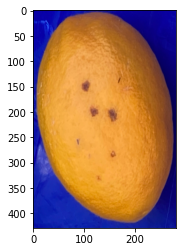

In [48]:
img = Image.open('../raw_data/lemons/IMG_3883.jpg').resize((640,640))

new_img = find_a_lemon(img)
plt.imshow(new_img);